In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparazione del Dataset:

###    - Caricamento e preprocessamento dei dati dei frutti esotici

In [2]:
# import direttamente dall'url
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'
df_fruit = pd.read_csv(url)
print("n_sample: "+str(len(df_fruit)))
print("\n")
print(df_fruit.head())

n_sample: 500


  Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0   Mela     86.40                89.68                  8.69   
1   Mela     77.58                73.45                  6.49   
2   Mela     81.95                81.66                  6.40   
3   Mela     66.33                36.71                  6.78   
4   Mela     56.73                75.69                  5.78   

   Durezza buccia (1-10)  Dolcezza (1-10)  
0                   9.61             2.41  
1                   7.20             3.87  
2                   9.09             2.88  
3                   8.21             2.55  
4                   9.15             3.88  


#### Tutte le feature sono continue

#### Andiamo a cercare eventuali dati mancanti nel dataset

In [3]:
# ricerca di eventuali colonne con dati mancanti
nan_counts = df_fruit.isna().sum()
print(nan_counts)

Frutto                   0
Peso (g)                 0
Diametro medio (mm)      0
Lunghezza media (mm)     0
Durezza buccia (1-10)    0
Dolcezza (1-10)          0
dtype: int64


#### Non ci sono colonne con dati mancanti

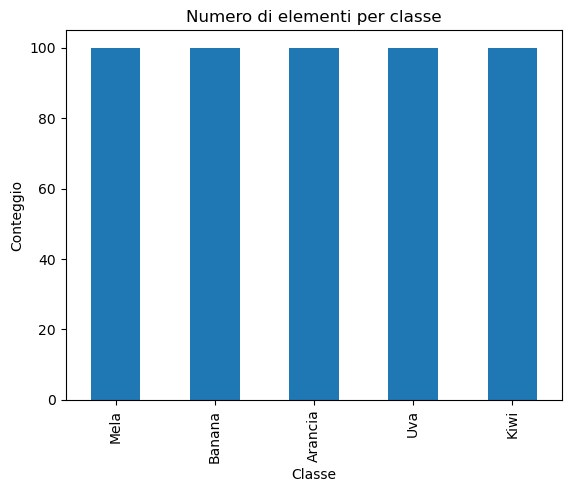

In [7]:
counts = df_fruit['Frutto'].value_counts()

counts.plot(kind='bar')

plt.title('Numero di elementi per classe')
plt.xlabel('Classe')
plt.ylabel('Conteggio')

plt.show()

#### Il dataset è perfettamente equilibrato, con 100 elementi per ogni classe

# 2. Implementazione del modello KNN e 3. Valutazione delle Performance

In [16]:
X = df_fruit.drop(columns=['Frutto'])
y = df_fruit['Frutto']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Standardizzazione 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Definizione del modello
knn = KNeighborsClassifier()

# Definizione della griglia degli iperparametri da testare
param_grid = {
    'n_neighbors': np.arange(1, 31),  # Numero di vicini
    'weights': ['uniform', 'distance'],  # Peso uniforme o basato sulla distanza
    'metric': ['minkowski'],  # Metrica fissata su minkowski
    'p': np.arange(1, 6)  # Ordine della distanza di Minkowski
}

# Esecuzione del Grid Search con cross-validation 5-fold
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("migliori iperparametri: ")
print(best_params)
best_score = -grid_search.best_score_
print("miglior accuracy ottenuta: " + str(-best_score))
best_model = grid_search.best_estimator_

migliori iperparametri: 
{'metric': 'minkowski', 'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
miglior accuracy ottenuta: 0.8525


#### Calcolo delle metriche

In [33]:
# Predizioni sul test set
y_pred = best_model.predict(X_test)

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: "+str(accuracy))
precision = precision_score(y_test, y_pred, average='weighted')
print("precision: "+str(precision))        
recall = recall_score(y_test, y_pred, average='weighted')
print("recall: "+str(recall))
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score: "+str(f1))
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy: 0.86
precision: 0.8775091575091575
recall: 0.86
f1 score: 0.8621595795508838


# 4. Visualizzazione dei risultati

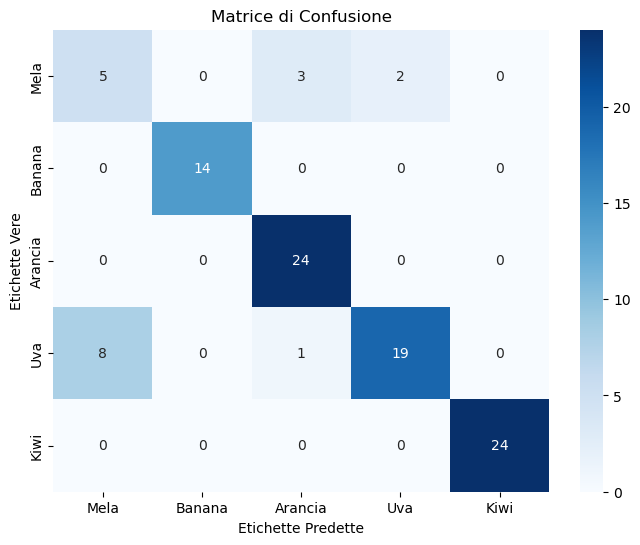

In [46]:
class_names = y.unique()

# Visualizzazione della matrice di confusione come heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice di Confusione')
plt.xlabel('Etichette Predette')
plt.ylabel('Etichette Vere')
plt.show()

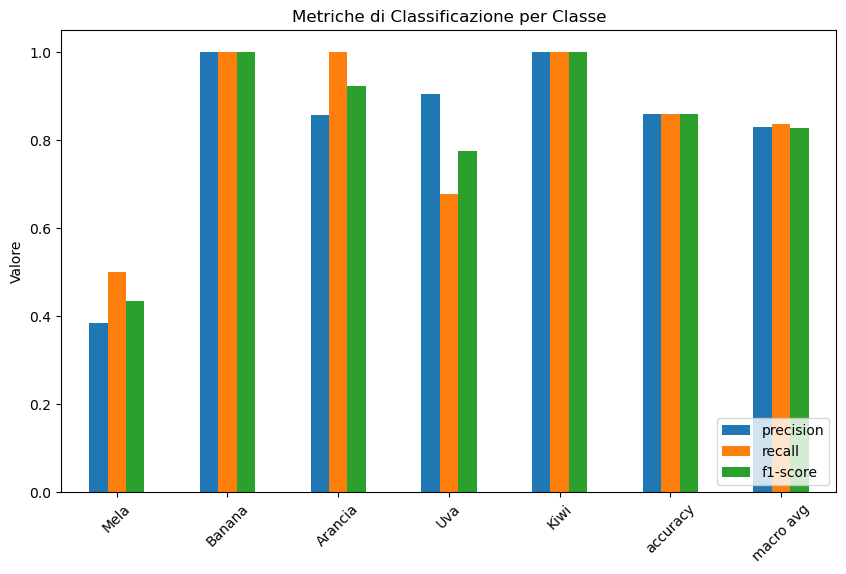

In [48]:
# Generazione del report di classificazione
class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Visualizzazione delle metriche: precisione, richiamo, F1-score
metrics_df = pd.DataFrame(class_report).transpose().iloc[:-1, :3]  # Escludiamo 'accuracy' e 'support'
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Metriche di Classificazione per Classe')
plt.ylabel('Valore')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

#### Gli errori sono per la maggior parte nella classe "uva", che viene spesso confusa con la classe "mela", e nella classe "mela" che viene spesso confusa con "uva" o con "arancia"

#### Potrebbe essere utile cercare di visualizzare come sono disposti i dati, magari in uno spazio bidimensionale o tridimensionale utilizzando tecniche di riduzione della dimensionalità (come la PCA); in questo modo potremmo cercare di capire se ci sono delle sovrapposizioni negli elementi di queste classi, oppure se ci sono alcuni outliers che potrebbero contribuire agli errori di classificazione.